# Simple Image Classification using VGG19

This code template is for image classification using VGG19 model.

<img src="https://cdn.blobcity.com/assets/gpu_required.png"  height="25" style="margin-bottom:-15px" />

## Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG19
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

An Image occupies a significant portion of space. Since images represent huge datasets, loading them at once to memory (RAM) can lead to severe scalibility issues and memory limitations. Therefore, in practice, images are loaded directly from the directory structure.   

TensorFlow 2 comes with a handy class called <Code>ImageDataGenerator</Code> that augments images. It takes the following parameters:


1. **rotation_range**:	Int. 
>Degree range for random rotations.

2. **width_shift_range**: Float, 1-D array-like or int
          * float: fraction of total width, if < 1, or pixels if >= 1.
          * 1-D array-like: random elements from the array.
          * int: integer number of pixels from interval (-width_shift_range, +width_shift_range)
          * With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

3. **height_shift_range**:	Float, 1-D array-like or int. 
>Values have similar meaning as width_shift_range

4. **zoom_range**:	Float or [lower, upper]. 
>Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
channel_shift_range	Float. Range for random channel shifts.

5. **horizontal_flip**:	Boolean. 
>Randomly flip inputs horizontally.


6. **rescale**:	rescaling factor. Defaults to None. 
>If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

7. **data_format**	Image data format, either "channels_first" or "channels_last". 
>"channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width). 


For More Info: [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

## Flow From Directory

<Code>ImageDataGenerator</Code> class uses the method <Code>flow_from_directory</Code> to load the images. However, for this method to work, it is necessary the directory follow the above directory structure.

<Code>flow_from_directory</Code> takes the path to a directory & generates batches of augmented data. It takes following parameters:

1. **directory**:	string, path to the target directory. 
>It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator. 

2. **target_size**:	Tuple of integers (height, width), defaults to (256,256). 
>The dimensions to which all images found will be resized.
color_mode	One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

3. **classes**:	Default: None. 
>Optional list of class subdirectories (e.g. ['dogs', 'cats']). 

4. **class_mode**:	Default: "categorical". 
>One of "categorical", "binary", "sparse", "input", or None. 

5. **batch_size**:	Default: 32
>Size of the batches of data.

6. **shuffle**: Default: True
>Whether to shuffle the data. If set to False, sorts the data in alphanumeric order.

For More Info: [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [2]:
train_datagenerator = ImageDataGenerator(rescale=1./255,
                                         rotation_range=20,
                                         width_shift_range=.15,
                                         height_shift_range=.15,
                                         horizontal_flip=True,
                                         zoom_range=0.2,
                                         data_format = "channels_last")

test_datagenerator = ImageDataGenerator(rescale = 1./255)

In [3]:
target=['cats','dogs']

In [52]:
batch_size = 64 # number of images to process at a time 
IMG_SHAPE = 128 # convert all images to be 224 x 224

train_data = train_datagenerator.flow_from_directory(directory = '',
                                                     batch_size = batch_size,
                                                     target_size = (IMG_SHAPE, IMG_SHAPE),
#                                                      shuffle = True, #for training only
                                                     class_mode = 'sparse', #type of problem (sparse, binary, or categorical, etc.)
                                                     classes = target)  

test_data = test_datagenerator.flow_from_directory(directory = '',
                                                   batch_size = batch_size,
                                                   target_size = (IMG_SHAPE, IMG_SHAPE),
#                                                    shuffle = False,
                                                   class_mode = 'sparse',
                                                   classes = target)

Found 2014 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model

**VGG19** is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs.

**parameters :**
>**include_top:** whether to include the 3 fully-connected layers at the top of the network.

>**weights:** one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

>**input_tensor:** optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

>**input_shape:** optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) or (3, 224, 224) (with channels_first data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

>**classes:** optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

>**classifier_activation:** A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".

In [60]:
loss = "binary_crossentropy" 
output_activation = 'sigmoid'
learning_rate = 0.0005 #Default = 0.001
epochs = 6
NUM_COLOR_CHANNELS = 3

In [61]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

In [62]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation=output_activation))

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 20,548,801
Trainable params: 20,548,801
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.compile(loss=loss,
              optimizer=optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['acc'])

In [65]:
history = model.fit(train_data,
                    epochs=epochs,
                   validation_data=test_data)

Epoch 1/6
32/32 [==============================] - 1045s 32s/step - loss: 569.8585 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.4920
Epoch 2/6
32/32 [==============================] - 1019s 32s/step - loss: 0.6964 - acc: 0.4980 - val_loss: 0.6968 - val_acc: 0.5000
Epoch 3/6
32/32 [==============================] - 1037s 32s/step - loss: 0.7059 - acc: 0.5333 - val_loss: 0.7001 - val_acc: 0.5000
Epoch 4/6
32/32 [==============================] - 1021s 32s/step - loss: 0.6986 - acc: 0.5372 - val_loss: 0.6894 - val_acc: 0.5380
Epoch 5/6
32/32 [==============================] - 991s 31s/step - loss: 0.8267 - acc: 0.5144 - val_loss: 0.6927 - val_acc: 0.5020
Epoch 6/6
32/32 [==============================] - 1022s 32s/step - loss: 0.8002 - acc: 0.4975 - val_loss: 0.6930 - val_acc: 0.5000


In [66]:
def plot_model(model_name_history, metric_name):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot accuracy per iteration
    ax[1].plot(model_name_history.history[metric_name], label='accuracy')
    ax[1].plot(model_name_history.history[f"val_{metric_name}"], label='val_accuracy')
    ax[1].legend()

## Plot Curves

Plot loss and accuracy metrics to see how the model trains

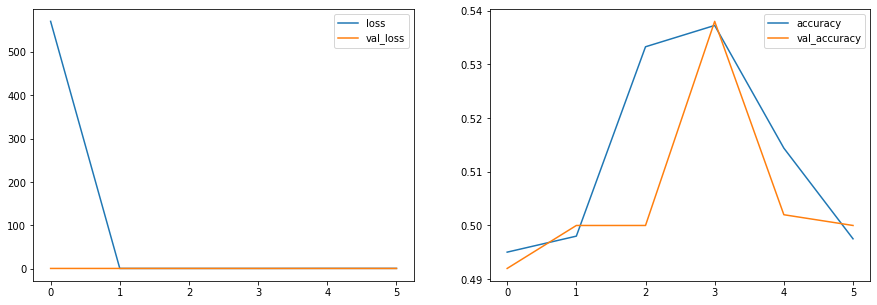

In [67]:
plot_model(history,'acc')

## Model Evaluation

In [68]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions,axis = 1)
y_test = test_data.classes
class_labels = list(test_data.class_indices.keys())   
loss, accuracy = model.evaluate(test_data)
print("Loss: ", loss)
print("Accuracy Score: ",accuracy)

16/16 [==============================] - 112s 7s/step - loss: 0.6930 - acc: 0.5000
Loss:  0.692980945110321
Accuracy Score:  0.5


## Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

In [69]:
def get_confusion_matrix(data, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in data:
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        y_pred = np.argmax(p,axis = 1)
        predictions = np.concatenate((predictions, y_pred))
 
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm

Generating confusion matrix 16


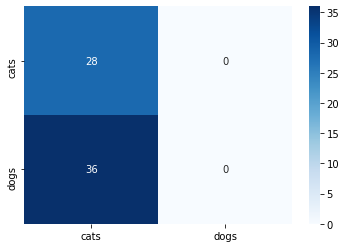

In [70]:
cm = get_confusion_matrix(test_data, len(test_data))
sns.heatmap(cm,
            annot = True,
            fmt = 'd',
            xticklabels=class_labels, 
            yticklabels= class_labels,
            cmap = plt.cm.Blues)
plt.show()

## Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       500
           1       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



## Creator:Abhishek Garg ,Github [Profile](https://github.com/abhishek-252)